In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import matplotlib.cm as cm
import matplotlib.dates as mdates
from scipy.signal import find_peaks
import openmeteo_requests
import requests_cache
from datetime import date, timedelta
import seaborn as sns
import numpy as np
import os
import sys
import pygam
import sklearn
sys.path.append("..")
from pygam import LinearGAM, f, s, te 


citing pyGAM: Servén D., Brummitt C. (2018). pyGAM: Generalized Additive Models in Python. Zenodo. DOI: 10.5281/zenodo.1208723

In [3]:
# data load 
mstl_data = pd.read_csv("../data/mstl_results_clean.csv", low_memory=False)

In [4]:
# Übersicht über mstl_data Columns
mstl_data.columns.tolist()

['timestamp',
 'city',
 'counter_site',
 'longitude',
 'latitude',
 'count',
 'count_capped',
 'log_count',
 'trend',
 'seasonal_24',
 'seasonal_168',
 'seasonal_8766',
 'residual']

In [5]:
# extrahiere benötigte Spalten für GAMS
residual_data = mstl_data[['timestamp',
 'city',
 'counter_site',
 #'longitude',
 #'latitude',
 #'count',
 #'count_capped',
 #'log_count',
 'seasonal_8766',
 'residual']].copy()
# filtert Zeilen raus, in denen anstatt Werten die Columnnames stehen
residual_data = residual_data[residual_data['timestamp']!='timestamp']

In [6]:
residual_data['id'] = residual_data.groupby(['city', 'counter_site']).ngroup()

In [7]:
len(list(set(residual_data['id'].to_list())))

77

In [18]:
residual_data['year_plus_res'] = residual_data['residual'].astype(float).values + residual_data['seasonal_8766'].astype(float).values
residual_data.head(2)

,timestamp,city,counter_site,seasonal_8766,residual,id,year_plus_res
0,2012-12-31 23:00:00+00:00,Landeshauptstadt Stuttgart,König-Karls-Brücke Barometer,-1.8545503347710663,0.30620344321336024,5,-1.548347
1,2013-01-01 00:00:00+00:00,Landeshauptstadt Stuttgart,König-Karls-Brücke Barometer,-0.9312113949920525,0.7172102469645241,5,-0.214001


In [11]:
# load weather data 
weather_data = pd.read_csv("../data/weather_per_city.csv", low_memory=False)
print(weather_data.head(2))
print(weather_data.isna().sum())

                        date  temperature_2m  apparent_temperature  rain  \
0  2012-12-30 23:00:00+00:00          5.8285              1.619927   0.0   
1  2012-12-31 00:00:00+00:00          5.8285              1.688656   0.0   

   snowfall  forecast_temperature_2m  forecast_apparent_temperature  \
0       0.0                      NaN                            NaN   
1       0.0                      NaN                            NaN   

   forecast_rain  forecast_snowfall                        city  
0            NaN                NaN  Landeshauptstadt Stuttgart  
1            NaN                NaN  Landeshauptstadt Stuttgart  
date                                   0
temperature_2m                         0
apparent_temperature                   0
rain                                   0
snowfall                               0
forecast_temperature_2m          1586134
forecast_apparent_temperature    1586134
forecast_rain                    1586156
forecast_snowfall              

In [9]:
print(weather_data.columns.tolist())

['date', 'temperature_2m', 'apparent_temperature', 'rain', 'snowfall', 'forecast_temperature_2m', 'forecast_apparent_temperature', 'forecast_rain', 'forecast_snowfall', 'city']


In [12]:
# standardisiere weather_data mit mean und standard abweichung in den spalten ['temperature_2m', 'apparent_temperature', 'rain', 'snowfall', 'forecast_temperature_2m', 'forecast_apparent_temperature', 'forecast_rain', 'forecast_snowfall']
for col in ['temperature_2m', 'apparent_temperature', 'rain', 'snowfall', 'forecast_temperature_2m', 'forecast_apparent_temperature', 'forecast_rain', 'forecast_snowfall']:
    mean = weather_data[col].mean()
    std = weather_data[col].std()
    weather_data[col] = (weather_data[col] - mean) / std    
    print(mean, std)

10.855987184053387 7.979670552541313
8.91802290321358 9.53659238828268
0.10174128754799047 0.38657121849145865
0.005151963446249264 0.04783389859722667
11.823547438992131 7.808666954712097
10.201564167151755 9.212069657387984
0.08441595272740929 0.5203236479169312
0.0017633119331499222 0.029863864122869815


In [19]:
# merge with weather data by city and date (in weather data) and timestamp (in residual data)
merged_data = pd.merge(residual_data, weather_data, left_on=['city', residual_data['timestamp']], right_on=['city', weather_data['date']], how='left')

print(merged_data.shape)
merged_data.isna().sum()

(3678215, 17)


timestamp                              0
key_1                                  0
city                                   0
counter_site                           0
seasonal_8766                          0
residual                               0
id                                     0
year_plus_res                          0
date                               18750
temperature_2m                     18750
apparent_temperature               18750
rain                               18750
snowfall                           18750
forecast_temperature_2m          1327608
forecast_apparent_temperature    1327608
forecast_rain                    1327657
forecast_snowfall                1327657
dtype: int64

In [20]:
print(residual_data.shape)
print(merged_data.shape)
residual_data.isna().sum()

(3678215, 7)
(3678215, 17)


timestamp        0
city             0
counter_site     0
seasonal_8766    0
residual         0
id               0
year_plus_res    0
dtype: int64

In [22]:
# Referenzzeitpunkt (UTC)
ref = pd.Timestamp(min(residual_data['timestamp'].tolist())) 
print(ref)

# 1) Spalte vektorisert in Datetime konvertieren (einmalig)
t_0 = pd.to_datetime(merged_data['timestamp'], utc=True, errors='coerce')

# 2) Differenz in Stunden berechnen (vektorisiert)
merged_data['timestamp_number'] = (t_0 - ref).dt.total_seconds() / 3600.0

# => timestamp_number ist jetzt die Anzahl Stunden seit Referenzzeitpunkt

2012-12-31 23:00:00+00:00


In [23]:
y = merged_data['year_plus_res'] #.astype(float).values
X = merged_data[['timestamp_number', 'id', 'temperature_2m', 'rain', 'snowfall']].astype(float).values
# drop rows with NaN values in X or y
mask = ~np.isnan(y) & ~np.isnan(X).any(axis=1)
y = y[mask]
X = X[mask]

In [24]:
merged_data.isna().sum()

timestamp                              0
key_1                                  0
city                                   0
counter_site                           0
seasonal_8766                          0
residual                               0
id                                     0
year_plus_res                          0
date                               18750
temperature_2m                     18750
apparent_temperature               18750
rain                               18750
snowfall                           18750
forecast_temperature_2m          1327608
forecast_apparent_temperature    1327608
forecast_rain                    1327657
forecast_snowfall                1327657
timestamp_number                       0
dtype: int64

Empfehlung von ChatGPT:
gam = LinearGAM(
    s(0, n_splines=10) +                 # timestamp_days (drift)
    f(1, lam=20) +                       # counter_site_id
    s(2, n_splines=8) +                  # temp_anom
    s(3, n_splines=6) +                  # temp_diff
    f(4) + s(5) +                        # rain
    f(6) + s(7) +                        # snow
    te(2, 5, n_splines=5)                # temp × rain
).fit(X, y)

X = [
    timestamp_days,
    counter_site_id,
    temp_anom,
    temp_diff,
    rain_bin,
    rain_log,
    snow_bin,
    snow_log
]

gam.statistics_['pseudo_r2']
gam.statistics_['AIC']

temp_anom = temperature_2m - temperature_2m.mean()
temp_diff = apparent_temperature - temperature_2m

rain_bin = (rain > 0).astype(int)
rain_log = np.log1p(rain)

snow_bin = (snowfall > 0).astype(int)
snow_log = np.log1p(snowfall)


In [25]:
gam = LinearGAM(
    s(0, n_splines=10, lam=1) +          # timestamp_number (drift)
    f(1, lam=50) +                       # id
    s(2, n_splines=6) +                  # temp
    s(3, n_splines=5, lam=2) +                               # rain
    s(4, n_splines=5, lam=2) +                               # snow
    te(2, 3, n_splines=4, lam=2)              # temp × rain
).fit(X, y)

In [26]:
print(gam.statistics_['pseudo_r2'])
print(gam.statistics_['AIC'])

OrderedDict([('explained_deviance', np.float64(0.2817560411773481)), ('McFadden', np.float64(0.750830767150413)), ('McFadden_adj', np.float64(0.2491356075677772))])
4325881.839857282


Modell 1: 
gam = LinearGAM( s(0, n_splines=10, lam=1) + # timestamp_number (drift) f(1, lam=50) + # id s(2, n_splines=8) + # temp s(3) + # rain s(4) + # snow te(2, 3, n_splines=5) # temp × rain ).fit(X, y)
=> OrderedDict([('explained_deviance', np.float64(0.05296875067989493)), ('McFadden', np.float64(0.8915546989156158)), ('McFadden_adj', np.float64(0.10831734354213729))])
AIC: 1682901.8363863465

Modell 2: 
gam = LinearGAM(
    s(0, n_splines=10, lam=1) +          # timestamp_number (drift)
    f(1, lam=50) +                       # id
    s(2, n_splines=6) +                  # temp
    s(3, n_splines=5, lam=2) +                               # rain
    s(4, n_splines=5, lam=2) +                               # snow
    te(2, 3, n_splines=4, lam=2)              # temp × rain
).fit(X, y)
=> OrderedDict([('explained_deviance', np.float64(0.2817560411773481)), ('McFadden', np.float64(0.750830767150413)), ('McFadden_adj', np.float64(0.2491356075677772))])
AIC: 4325881.839857282

Idee: sowohl bei Ist-Wetter als auch bei Vorhersage_Wetter Daten aus dem gleichen Zeitraum verwenden, für bessere Vergleichbarkeit der Ergebnisse?

City: Stadt Reutlingen, Input: weather, 
gam.statistics_["pseudo_r2"]: OrderedDict([('explained_deviance', np.float64(0.19616565163870603)), ('McFadden', np.float64(0.8270088765219982)), ('McFadden_adj', np.float64(0.17287015772269487))]), 
AIC: 376066.0913844274



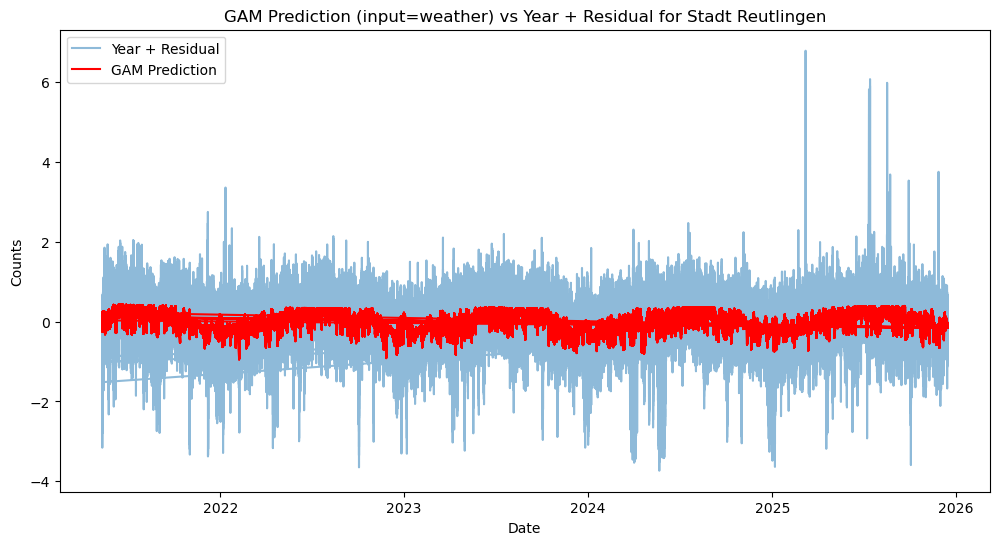

City: Stadt Reutlingen, Input: forecast, 
gam.statistics_["pseudo_r2"]: OrderedDict([('explained_deviance', np.float64(0.1914617739940233)), ('McFadden', np.float64(0.8319720343738307)), ('McFadden_adj', np.float64(0.16790970828185325))]), 
AIC: 377945.4846723334



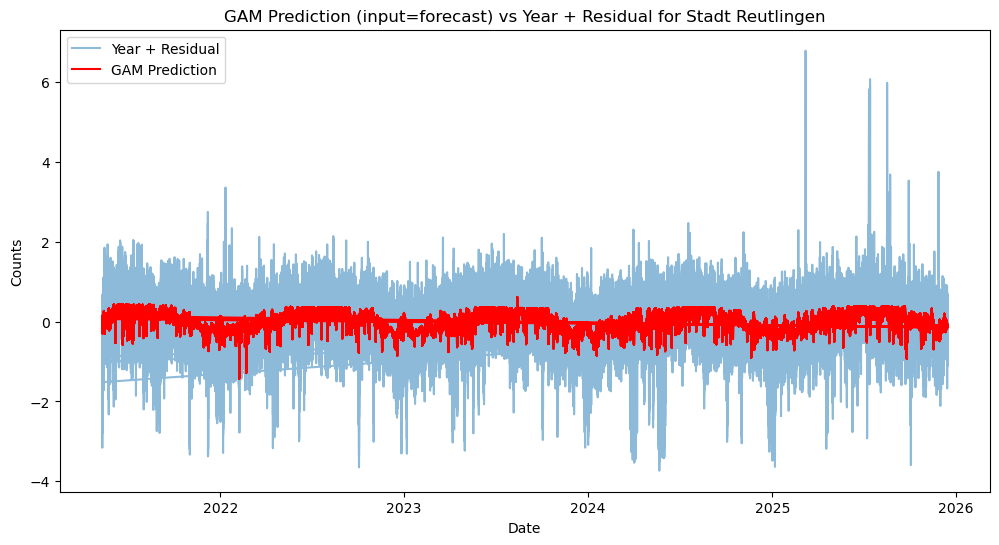

City: Stadt Tübingen, Input: weather, 
gam.statistics_["pseudo_r2"]: OrderedDict([('explained_deviance', np.float64(0.33888460433845524)), ('McFadden', np.float64(0.6868281203544344)), ('McFadden_adj', np.float64(0.3130516544574611))]), 
AIC: 281972.8138907955



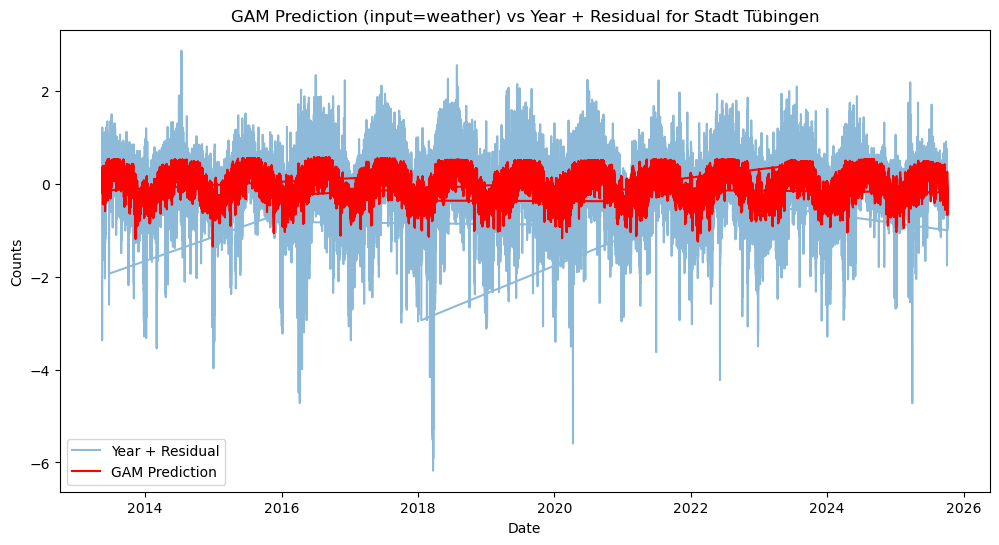

City: Stadt Tübingen, Input: forecast, 
gam.statistics_["pseudo_r2"]: OrderedDict([('explained_deviance', np.float64(0.304813538317976)), ('McFadden', np.float64(0.6810548101715509)), ('McFadden_adj', np.float64(0.3186001185730385))]), 
AIC: 78875.51262057979



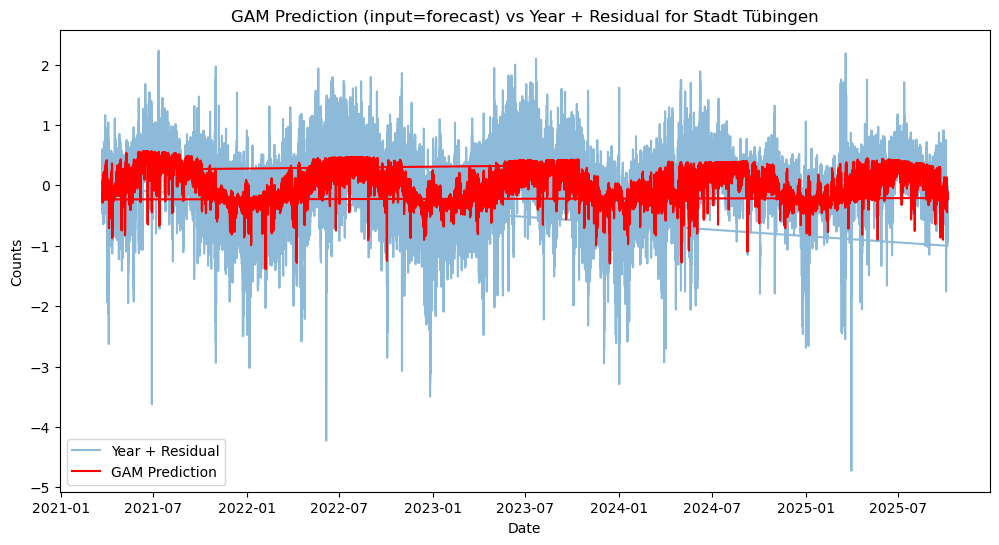

City: Landeshauptstadt Stuttgart, Input: weather, 
gam.statistics_["pseudo_r2"]: OrderedDict([('explained_deviance', np.float64(0.37419046625366337)), ('McFadden', np.float64(0.6810702615767149)), ('McFadden_adj', np.float64(0.31888609810742097))]), 
AIC: 1113281.6185413864



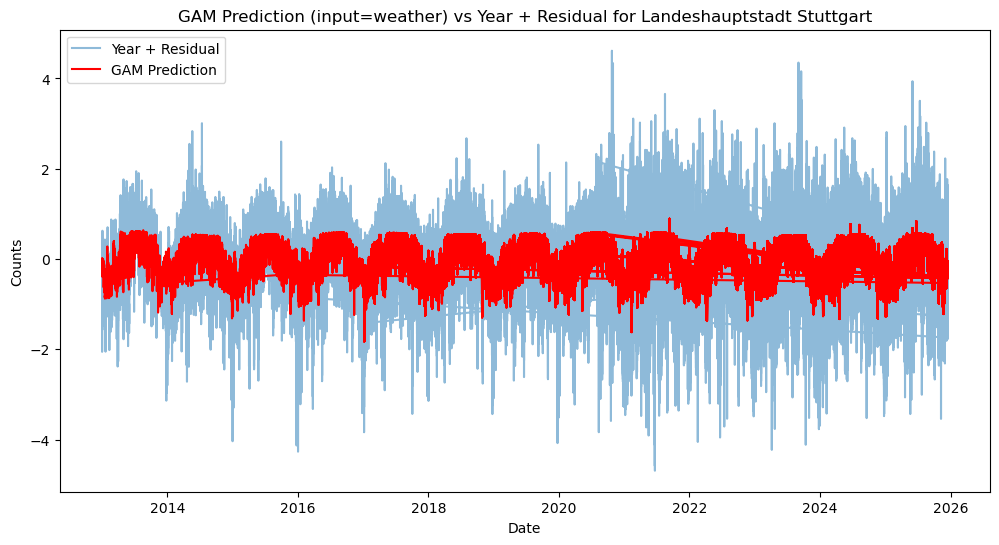

City: Landeshauptstadt Stuttgart, Input: forecast, 
gam.statistics_["pseudo_r2"]: OrderedDict([('explained_deviance', np.float64(0.35167356526623883)), ('McFadden', np.float64(0.6996518143164953)), ('McFadden_adj', np.float64(0.3002880446282068))]), 
AIC: 777894.4120300064



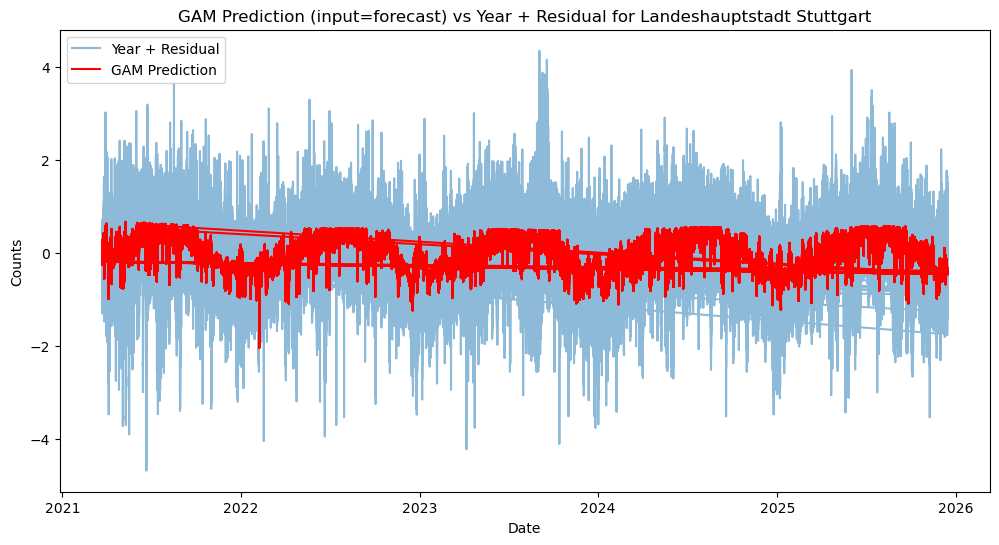

City: Stadt Freiburg, Input: weather, 
gam.statistics_["pseudo_r2"]: OrderedDict([('explained_deviance', np.float64(0.21991761188317427)), ('McFadden', np.float64(0.7867085793081156)), ('McFadden_adj', np.float64(0.2131796190181281))]), 
AIC: 316720.8675655739



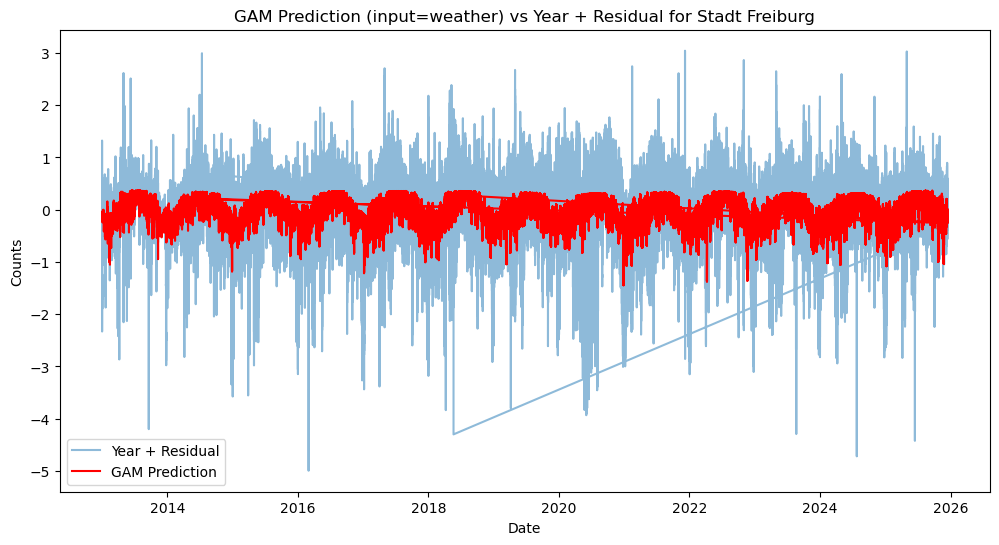

City: Stadt Freiburg, Input: forecast, 
gam.statistics_["pseudo_r2"]: OrderedDict([('explained_deviance', np.float64(0.23933190472545274)), ('McFadden', np.float64(0.679495121212484)), ('McFadden_adj', np.float64(0.3201420091039219))]), 
AIC: 77445.80703791215



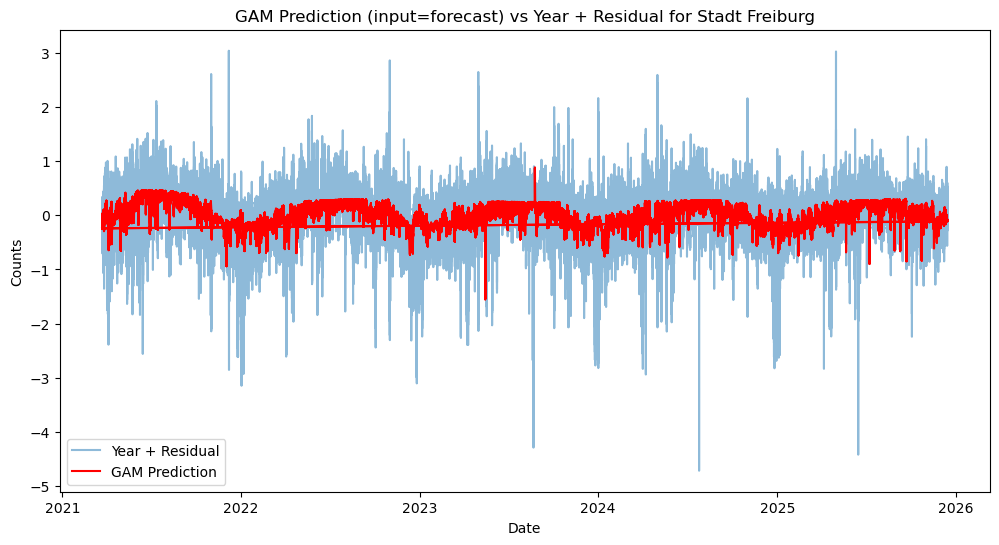

City: Stadt Heidelberg, Input: weather, 
gam.statistics_["pseudo_r2"]: OrderedDict([('explained_deviance', np.float64(0.21800474110804013)), ('McFadden', np.float64(0.8053892507589224)), ('McFadden_adj', np.float64(0.19454006084372588))]), 
AIC: 804976.1590337866



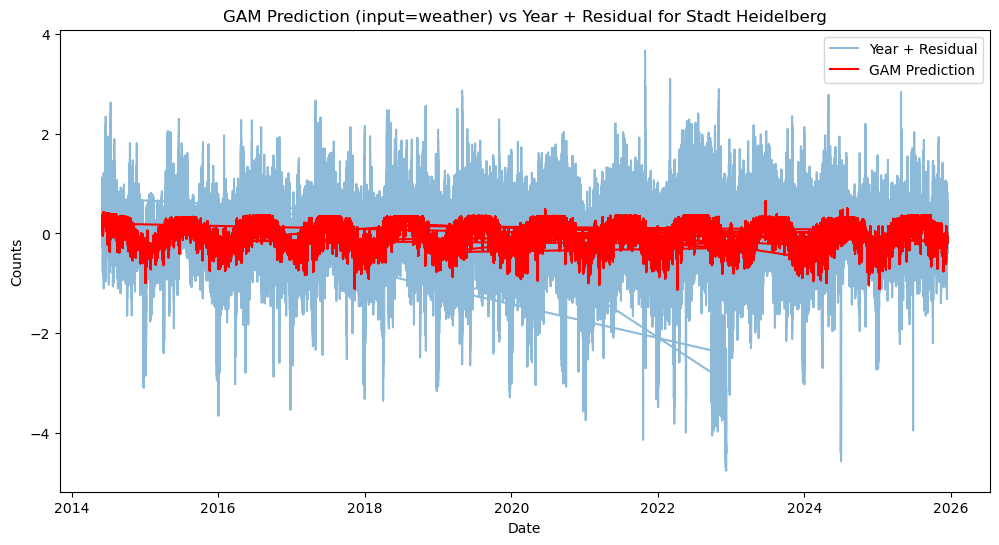

City: Stadt Heidelberg, Input: forecast, 
gam.statistics_["pseudo_r2"]: OrderedDict([('explained_deviance', np.float64(0.17916638979571042)), ('McFadden', np.float64(0.8451281126518924)), ('McFadden_adj', np.float64(0.15472445508297772))]), 
AIC: 373900.6977577492



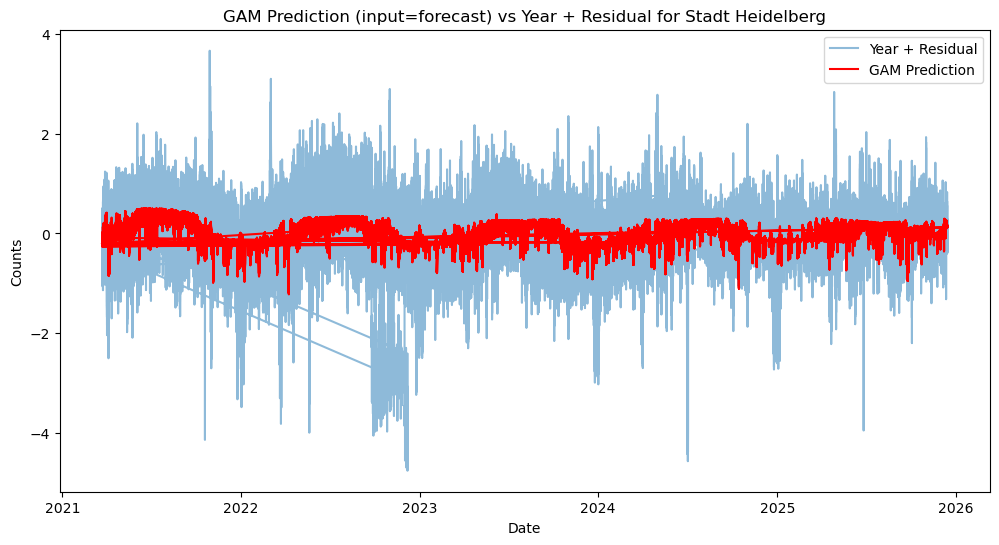

City: Stadt Ludwigsburg, Input: weather, 
gam.statistics_["pseudo_r2"]: OrderedDict([('explained_deviance', np.float64(0.32191639448140985)), ('McFadden', np.float64(0.7185609952333889)), ('McFadden_adj', np.float64(0.2813748146061943))]), 
AIC: 773584.2967551136



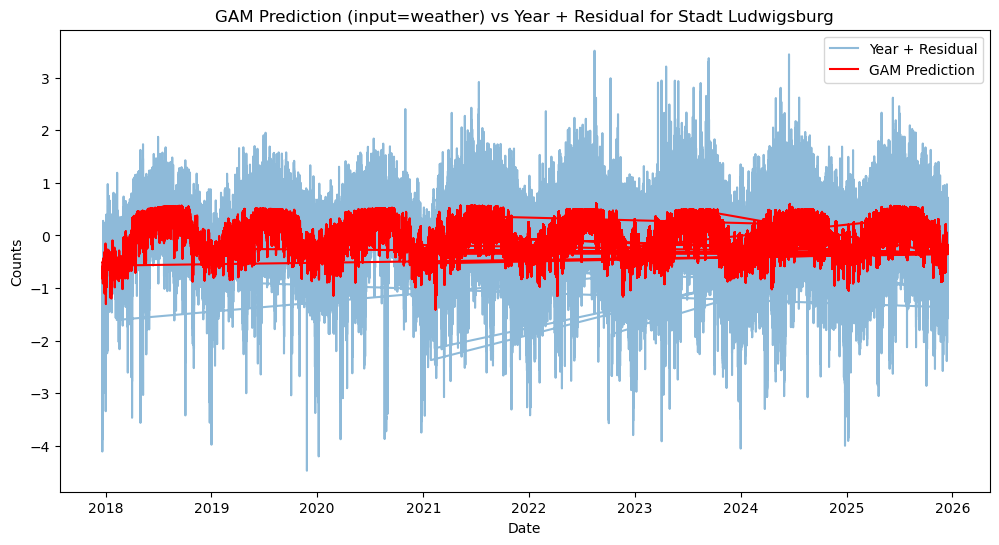

City: Stadt Ludwigsburg, Input: forecast, 
gam.statistics_["pseudo_r2"]: OrderedDict([('explained_deviance', np.float64(0.3229255329511488)), ('McFadden', np.float64(0.7111407051745947)), ('McFadden_adj', np.float64(0.2887842485386227))]), 
AIC: 649770.5480201192



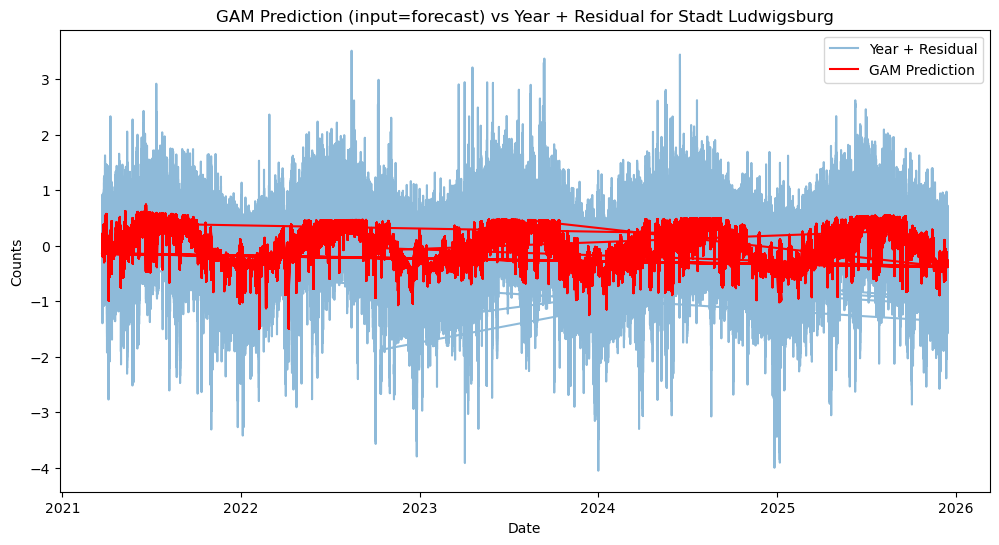

City: Stadt Mannheim, Input: weather, 
gam.statistics_["pseudo_r2"]: OrderedDict([('explained_deviance', np.float64(0.25209886878185706)), ('McFadden', np.float64(0.7462409660250714)), ('McFadden_adj', np.float64(0.25367691975279294))]), 
AIC: 569036.2838165933



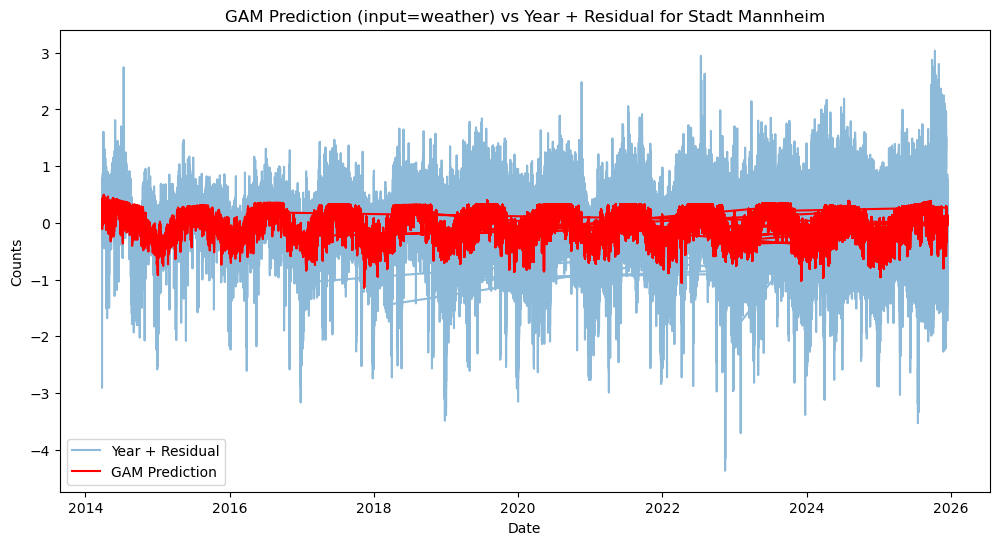

City: Stadt Mannheim, Input: forecast, 
gam.statistics_["pseudo_r2"]: OrderedDict([('explained_deviance', np.float64(0.1904579270589889)), ('McFadden', np.float64(0.8201915567207333)), ('McFadden_adj', np.float64(0.17967379577917075))]), 
AIC: 370386.58592287026



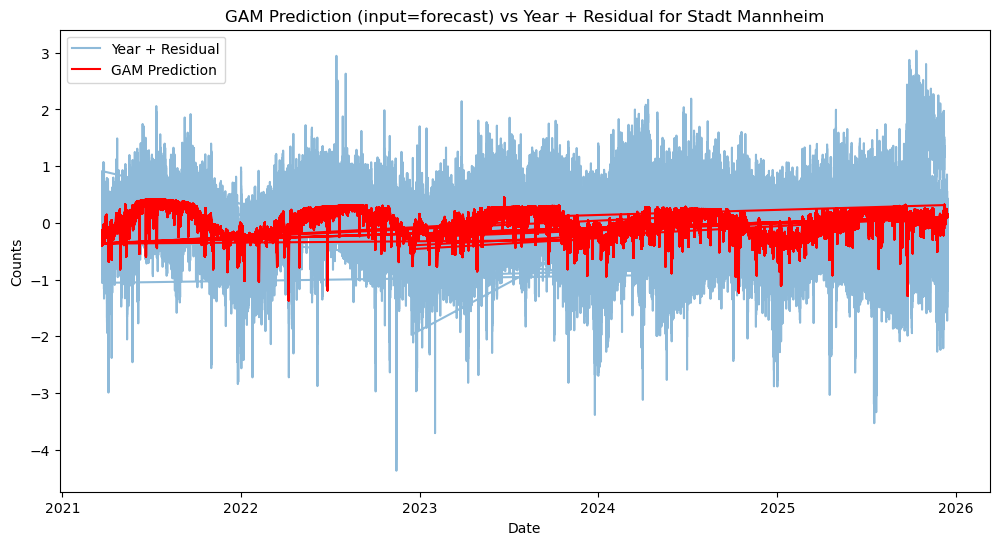

In [ ]:
# trainieren für jede Stadt einzeln (seperat für weather und forecast input)
cities = list(set(merged_data['city'].to_list()))

for c in cities:
    for input in ['weather', 'forecast']:
        city_data = merged_data[merged_data['city']==c]        
        X_city = city_data[['timestamp_number', 'id', 'temperature_2m', 'rain', 'snowfall']].astype(float).values if input=='weather' else \
                           city_data[['timestamp_number', 'id', 'forecast_temperature_2m', 'forecast_rain', 'forecast_snowfall']].astype(float).values
        y_city = city_data['year_plus_res']

        # drop rows with NaN values in X_city
        mask = ~np.isnan(y_city) & ~np.isnan(X_city).any(axis=1)
        X_city = X_city[mask]
        y_city = y_city[mask]
        city_data = city_data[mask]

        gam_city = LinearGAM(
            s(0, n_splines=10, lam=1) +          # timestamp_number (drift)
            f(1, lam=50) +                       # id
            s(2, n_splines=6) +                  # temp
            s(3, n_splines=5, lam=2) +                               # rain
            s(4, n_splines=5, lam=2) +                               # snow
            te(2, 3, n_splines=4, lam=2)              # temp × rain
        ).fit(X_city, y_city)
        print(f'City: {c}, Input: {input}, \ngam.statistics_["pseudo_r2"]: {gam_city.statistics_["pseudo_r2"]}, \nAIC: {gam_city.statistics_["AIC"]}\n') 

        city_data['gam_prediction'] = gam_city.predict(X_city)

        # plot weather data predictions
        plot_data = city_data.copy()
        plt.figure(figsize=(12,6))
        plt.plot(pd.to_datetime(plot_data['timestamp'], utc=True), plot_data['year_plus_res'], label='Year + Residual', alpha=0.5)
        plt.plot(pd.to_datetime(plot_data['timestamp'], utc=True), plot_data['gam_prediction'], label='GAM Prediction', color='red')
        plt.title(f'GAM Prediction (input={input}) vs Year + Residual for {c}')
        plt.xlabel('Date')
        plt.ylabel('Counts')
        plt.legend()
        plt.show()

Merksatz (wichtig!)

🔹 Für Gaussian-GAMs: nur explained_deviance ernst nehmen
🔹 5 % nach MSTL = starkes Ergebnis
🔹 AIC nur zum Modellvergleich, nie absolut

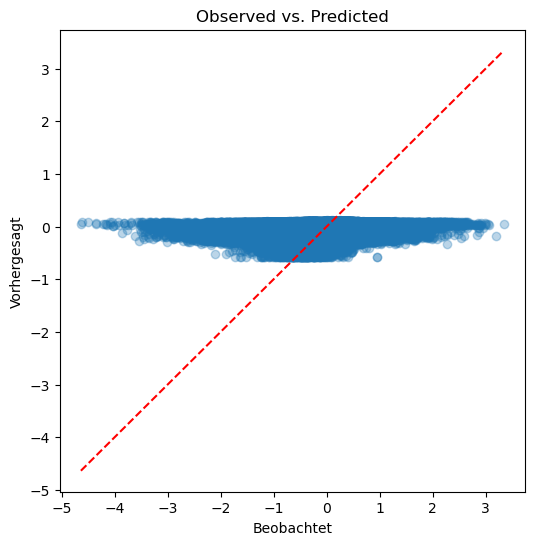

In [203]:
y_pred = gam.predict(X)

plt.figure(figsize=(6, 6))
plt.scatter(y, y_pred, alpha=0.3)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.xlabel("Beobachtet")
plt.ylabel("Vorhergesagt")
plt.title("Observed vs. Predicted")
plt.show()

In [151]:
gam.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     44.9328
Link Function:                     IdentityLink Log Likelihood:                               -702250.1506
Number of Samples:                      2761419 AIC:                                          1404592.1667
                                                AICc:                                         1404592.1683
                                                GCV:                                                0.0974
                                                Scale:                                               0.312
                                                Pseudo R-Squared:                                   0.0508
Feature Function                  Lam

C:\Users\johan\AppData\Local\Temp\ipykernel_29964\3358381670.py:1: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam.summary()


In [ ]:
# läuft auch durch, aber ist schlecht
# gam = LinearGAM(s(0) + f(1) + s(2) + s(3) + s(4) + s(5)).fit(X, y)